In [1]:
from gensim.models import Word2Vec
from tqdm import tqdm
import tqdm.notebook as tq
import pandas as pd
import nltk
import numpy as np
import gensim
from tqdm import tqdm
tqdm.pandas()
import itertools
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
nltk.download('punkt')
import os
import glob
import shutil
import re
import random as rn
import datetime
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to /home/dritsakon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    base_embed.init_sims()
    other_embed.init_sims()

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    # base_vecs = in_base_embed.syn0norm
    base_vecs = in_base_embed.wv.vectors_norm
    # other_vecs = in_other_embed.syn0norm
    other_vecs = in_other_embed.wv.vectors_norm
    
    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm) by "ortho"
    # other_embed.syn0norm = other_embed.syn0 = (other_embed.syn0norm).dot(ortho)
    other_embed.wv.vectors_norm = other_embed.wv.vectors = (other_embed.wv.vectors_norm).dot(ortho)
    return other_embed

def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1, m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count, reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = m.wv.vectors_norm
        new_arr = np.array([old_arr[index] for index in indices])
        # m.syn0norm = m.syn0 = new_arr
        m.wv.vectors_norm = m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.wv.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index, word in enumerate(common_vocab):
            old_vocab_obj = old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1, m2)

In [3]:
df = pd.read_csv('../out_files/tell_all_cleaned.csv')
df = df[df['speech'].notna()]

print('Preparing data...')

#New column year
df.sitting_date = pd.to_datetime(df.sitting_date, format="%d/%m/%Y") 
df['year'] = df['sitting_date'].dt.year
df['decade'] = (df['year']//10)*10
df = df[df.decade != 1980] # remove dates before 2000 to catch the three last decades
df = df[df.decade != 2020]# remove dates after 2019 to catch the three last decades
df = df[df.decade != 2000]# remove dates after 2019 to catch the three last decades

# df.speech = df.speech.progress_apply(lambda x: x.replace(".", " . ")) #add space around dot

print(set(df.decade.to_list()))

# concat sentences, each last sentence for each speech did not have dot so add one.
df.speech = df.speech.progress_apply(lambda x: x.replace('\n', ' '))
df.speech = df.speech.progress_apply(lambda x: re.sub('\s\s+' , ' ', x)) 

Preparing data...


  6%|▌         | 50475/860546 [00:00<00:01, 504746.87it/s]

{2010, 1990}


100%|██████████| 860546/860546 [00:14<00:00, 59652.90it/s]


In [4]:
df.speech.iloc[1]

'κυριοι συναδελφοι @sw προχωρησουμε @sw ορκωμοσια @sw συναδελφου βασιλη κοραχαη.παρακαλειται @sw βασιλης κοραχαης @sw προσελθει @sw @sw ορκισθει.ορκιζομαι @sw ονομα @sw αγιας @sw ομοουσιας @sw αδιαιρετης τριαδας @sw @sw πιστος @sw πατριδα @sw @sw δημοκρατικο πολιτευμα @sw υπακουω @sw συνταγμα @sw @sw νομους @sw @sw εκπληρω ευσυνειδητα @sw καθηκοντα @sw'

In [5]:
print('Group by decades...')
print(datetime.datetime.now())
PERdecade_df = df.groupby(df.decade)['speech'].progress_apply('.'.join).reset_index() #concat sentences, each last sentence for each speech did not have dot so add one.
PERdecade_df.speech = PERdecade_df.speech.progress_apply(lambda x: [sent.split(' ') for sent in x.split('.')])
print(PERdecade_df.head())



  0%|          | 0/2 [00:00<?, ?it/s]

Group by decades...
2021-04-14 18:09:53.829276


100%|██████████| 2/2 [00:38<00:00, 19.31s/it]


   decade                                             speech
0    1990  [[κυριοι, συναδελφοι, αρχιζει, @sw, συνεδριαση...
1    2010  [[κυριες, @sw, κυριοι, συναδελφοι, @sw, @sw, ε...


In [6]:
# PERdecade_df.speech[0] = PERdecade_df.speech[0][:100000]
# PERdecade_df.speech[1] = PERdecade_df.speech[1][:100000]
# print(len(PERdecade_df.speech.iloc[0]))
# print(len(PERdecade_df.speech.iloc[1]))

In [7]:
def compute_cosine_similarity(model1,model2,word):
    vector1 = model1.wv[word].reshape(1,-1)
    vector2 = model2.wv[word].reshape(1,-1)
    return(cosine_similarity(X=vector1, Y=vector2)[0][0])

def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]


In [8]:
shifts_PERdecade_list=[]

models_dir =  '../out_files/wordmodels/procrustes_stability/'

if not os.path.exists(models_dir):
    print('Creating models directory...')
    os.makedirs(models_dir)
    
#Create aligned folder
align_dest_dir = models_dir +'aligned/'
if not os.path.exists(align_dest_dir):
    print('Creating aligned models directory...')
    os.makedirs(align_dest_dir)

for i in range(2):
    
    if i==0:
        %env PYTHONHASHSEED=13
        np.random.seed(13)
        rn.seed(12345)
        my_seed = 12345
    else:
        %env PYTHONHASHSEED=64
        np.random.seed(64)
        rn.seed(54321)
        my_seed=54321
        
    print('********************************************************')
    print('Repeat No ', str(i))
    
    print(datetime.datetime.now())
    
    print('Training models for each decade...')

    for decade, texts in tqdm(zip(PERdecade_df.decade, PERdecade_df.speech)):
        print(decade)
    #     print(model)
        model = Word2Vec(sentences=texts, size=300, window=5, min_count=20, workers=1, seed=my_seed)
        model.save(models_dir+str(decade)+'_'+str(i)+ ".mdl")

    #sort dataframe by decade
    PERdecade_df.sort_values(by='decade')
    decades = sorted(PERdecade_df.decade.to_list())
    decade_pairs = step_one_pairs(decades)

    print(datetime.datetime.now())
    

    print('Aligning models...')
    print(datetime.datetime.now())

    for file in glob.glob(models_dir +str(decades[0])+'_'+str(i)+'.mdl*'):
        shutil.copy(file, align_dest_dir)
        
    m_t0 = Word2Vec.load(models_dir+str(decades[0])+'_'+str(i)+'.mdl')
    m_t1 = Word2Vec.load(models_dir+str(decades[1])+'_'+str(i)+'.mdl')
    m_t1_aligned = smart_procrustes_align_gensim(m_t0, m_t1)
    m_t1_aligned.save(align_dest_dir+str(decades[1])+'_'+str(i)+'.mdl')

    m1 = m_t0
    m2 = m_t1_aligned
    
    common_vocab = list(set(m1.wv.vocab).intersection(set(m2.wv.vocab)))
    print('Common vocab length... ', str(len(common_vocab)))
    print('Computing word similarity between decades....')

    for word in tq.tqdm(common_vocab):

        cos_sim = compute_cosine_similarity(m1, m2, word)
        most_similar_words_period0 = m1.wv.most_similar(positive=[word], topn=10)
        most_similar_words_period1 = m2.wv.most_similar(positive=[word], topn=10)
        shifts_PERdecade_list.append([i, decade_pairs[0], word, cos_sim, len(common_vocab), most_similar_words_period0, most_similar_words_period1])

    print(datetime.datetime.now())


0it [00:00, ?it/s]

Creating models directory...
Creating aligned models directory...
env: PYTHONHASHSEED=13
********************************************************
Repeat No  0
2021-04-14 18:10:35.787577
Training models for each decade...
1990


1it [07:27, 447.23s/it]

2010


2it [18:25, 552.97s/it]


2021-04-14 18:29:01.736241
Aligning models...
2021-04-14 18:29:01.736359
Common vocab length...  41583
Computing word similarity between decades....


0it [00:00, ?it/s]


2021-04-14 18:34:07.605424
env: PYTHONHASHSEED=64
********************************************************
Repeat No  1
2021-04-14 18:34:07.607325
Training models for each decade...
1990


1it [07:29, 449.16s/it]

2010


2it [18:25, 552.70s/it]


2021-04-14 18:52:33.016271
Aligning models...
2021-04-14 18:52:33.016393
Common vocab length...  41583
Computing word similarity between decades....



2021-04-14 18:57:38.748812


In [9]:
shifts_PERdecade_df = pd.DataFrame(shifts_PERdecade_list, columns = ['iteration', 'decade_pair', 'word', 
                                                                 'semantic_similarity', 'common_voc_size',
                                                                    'top10neighbors_1st_decade',
                                                                    'top10neighbors_2nd_decade'])
print(shifts_PERdecade_df.head(10))

   iteration   decade_pair            word  semantic_similarity  \
0          0  (1990, 2010)           σοφια             0.588502   
1          0  (1990, 2010)  απομακρυνθουμε             0.390017   
2          0  (1990, 2010)    εξαγγελλεται             0.398243   
3          0  (1990, 2010)      περιβαλλον             0.792852   
4          0  (1990, 2010)        προδοτες             0.740140   
5          0  (1990, 2010)        μεσαιους             0.801892   
6          0  (1990, 2010)        ερωτασθε             0.634536   
7          0  (1990, 2010)       επιζημιες             0.724186   
8          0  (1990, 2010)         ζαχαρως             0.741469   
9          0  (1990, 2010)      βιαιοτητες             0.713932   

   common_voc_size                          top10neighbors_1st_decade  \
0            41583  [(αγια, 0.76173335313797), (ολγα, 0.7425981760...   
1            41583  [(ρατσιστικες, 0.7075477838516235), (προσκολλη...   
2            41583  [(αλλαζε, 0.56261694431

In [10]:
set(shifts_PERdecade_df.iteration.to_list())

{0, 1}

In [11]:
jjj = shifts_PERdecade_df.word[0]
print(jjj)

σοφια


In [12]:
shifts_PERdecade_df.loc[(shifts_PERdecade_df.word==jjj)]

iteration   decade_pair   word  semantic_similarity  common_voc_size  \
0              0  (1990, 2010)  σοφια             0.588502            41583   
41583          1  (1990, 2010)  σοφια             0.580298            41583   

                               top10neighbors_1st_decade  \
0      [(αγια, 0.76173335313797), (ολγα, 0.7425981760...   
41583  [(αγια, 0.7542368173599243), (ολγα, 0.73689067...   

                               top10neighbors_2nd_decade  
0      [(πετρος, 0.6969798803329468), (αλεξανδρα, 0.6...  
41583  [(πετρος, 0.7219552993774414), (αλεξανδρα, 0.7...

In [13]:
print(shifts_PERdecade_df.describe())

shifts_PERdecade_df = shifts_PERdecade_df.sort_values('semantic_similarity')

print('Words with the lowest cosine similarity / highest change')
print(shifts_PERdecade_df.head(20))

print('Words with the highest cosine similarity / lowest change')
print(shifts_PERdecade_df.tail(20))
shifts_PERdecade_df.to_csv('../out_files/stability_procrustes_2_iterations_dif_seeds_1_worker.csv', index=False)

          iteration  semantic_similarity  common_voc_size
count  83166.000000         83166.000000          83166.0
mean       0.500000             0.687204          41583.0
std        0.500003             0.124204              0.0
min        0.000000            -0.068029          41583.0
25%        0.000000             0.613198          41583.0
50%        0.500000             0.709618          41583.0
75%        1.000000             0.782846          41583.0
max        1.000000             0.920709          41583.0
Words with the lowest cosine similarity / highest change
       iteration   decade_pair     word  semantic_similarity  common_voc_size  \
78855          1  (1990, 2010)     µονο            -0.068029            41583   
28772          0  (1990, 2010)     ντου            -0.063552            41583   
37272          0  (1990, 2010)     µονο            -0.063332            41583   
58270          1  (1990, 2010)     κεδε            -0.057485            41583   
67873          1

   iteration   decade_pair         word  semantic_similarity  common_voc_size  \
0          0  (1990, 2010)  δημιουργουν             0.916779            41583   
1          0  (1990, 2010)        κανει             0.915950            41583   

                           top10neighbors_1st_decade  \
0  [(δημιουργησουν, 0.8421351313591003), (δημιουρ...   
1  [(κανοντας, 0.6200669407844543), (κανουν, 0.60...   

                           top10neighbors_2nd_decade  
0  [(δημιουργησουν, 0.7880411744117737), (δημιουρ...  
1  [(κανουμε, 0.6111526489257812), (κανοντας, 0.5...  
       iteration   decade_pair  word  semantic_similarity  common_voc_size  \
41581          0  (1990, 2010)  µονο            -0.063332            41583   
41582          0  (1990, 2010)  ντου            -0.063552            41583   

                               top10neighbors_1st_decade  \
41581  [(σηµερα, 0.5679251551628113), (µια, 0.5530058...   
41582  [(παθολογου, 0.7959349155426025), (επιμελητου,...   

      

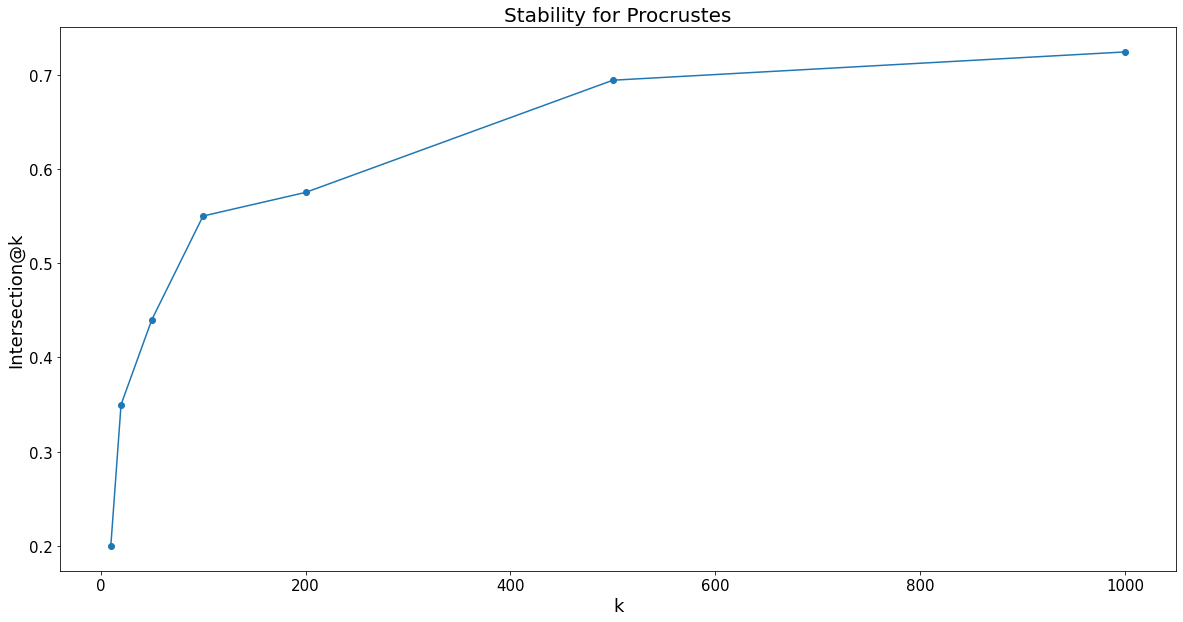

In [14]:
topn_dict = {}
X = []
Y = []
k=[10,20,50,100,200,500,1000]

for n in k:
    
    for iteration in range(2):
        subdf = shifts_PERdecade_df.loc[(shifts_PERdecade_df.iteration==iteration)]
#         print(subdf.shape)
    #     print(subdf.columns)
        subdf = subdf.sort_values(by='semantic_similarity', ascending=False).reset_index(drop=True)
        print(subdf.head(2))
        print(subdf.tail(2))
        topn_dict[iteration] = subdf.head(n).word.to_list()

    intersection = len(set(topn_dict[0]).intersection(set(topn_dict[1])))

    Y.append(intersection/n)
    X.append(n)
    
print(X,Y)

fig = plt.figure(figsize=(15, 8))

fig.set_size_inches(20, 10)
plt.scatter(X,Y)
plt.plot(X,Y)
plt.gca().tick_params(axis='both', which='major', labelsize=15)

plt.xlabel('k', fontsize=18)
plt.ylabel('Intersection@k', fontsize=18)
plt.title('Stability for Procrustes', fontsize=20)

plt.savefig('../out_files/stability_procrustes.png', dpi=200,  bbox_inches='tight')
